<a href="https://colab.research.google.com/github/zyntonyson/Erisk2017/blob/master/03_CNN_Glove_Early_Detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

##  CNN with Glove Embeddings


### Cargar datos


In [0]:

from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
import os
mypath='/content/drive/My Drive/MCE/Participaciones/05.Estancia Jun19/Practicas NLP/Deteccion de depresion/Actualizacion sep 2019'
os.chdir( mypath )

In [0]:
import pandas as pd
import numpy as np

df_train=pd.read_csv('train_Depression_all_chunks_nosteem.csv')
df_train=df_train.replace(np.nan, '', regex=True)
df_test=pd.read_csv('test_Depression_all_chunks_nosteem.csv')
df_test=df_test.replace(np.nan, '', regex=True)

In [0]:
def generate_data(df,nchunks=1):
  data=df['Chunk_1']
  data.rename(columns={'Chunk_1': 'x'})
  if nchunks<=1:
   pass
  else:
    for i in range(2,nchunks):
      chunk='Chunk_'+str(i)
      data+=df[chunk]
  return data.values

## Cargar Embbeding Pre-entrenado




In [0]:
#google word2vec pretrained embedding 

#!wget -P /root/input/ -c "https://s3.amazonaws.com/dl4j-distribution/GoogleNews-vectors-negative300.bin.gz"

In [0]:
#Fasttext embedding wikipedia

#!wget -P /root/input/ -c "https://dl.fbaipublicfiles.com/fasttext/vectors-english/wiki-news-300d-1M-subword.bin.zip"

In [0]:
#https://www.geeksforgeeks.org/working-zip-files-python/
#from zipfile import ZipFile 

#zipw=ZipFile('/root/input/wiki-news-300d-1M-subword.bin.zip', 'r')

#zipw.extract('wiki-news-300d-1M-subword.bin',path="/root/input")

In [0]:
# Glove
!wget -P /root/input/ -c "http://nlp.stanford.edu/data/glove.6B.zip"

--2019-10-13 07:54:32--  http://nlp.stanford.edu/data/glove.6B.zip
Resolving nlp.stanford.edu (nlp.stanford.edu)... 171.64.67.140
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:80... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://nlp.stanford.edu/data/glove.6B.zip [following]
--2019-10-13 07:54:33--  https://nlp.stanford.edu/data/glove.6B.zip
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: http://downloads.cs.stanford.edu/nlp/data/glove.6B.zip [following]
--2019-10-13 07:54:33--  http://downloads.cs.stanford.edu/nlp/data/glove.6B.zip
Resolving downloads.cs.stanford.edu (downloads.cs.stanford.edu)... 171.64.64.22
Connecting to downloads.cs.stanford.edu (downloads.cs.stanford.edu)|171.64.64.22|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 862182613 (822M) [application/zip]
Saving to: ‘/root/input/glove.6B.z

In [0]:
from zipfile import ZipFile 

zip=ZipFile('/root/input/glove.6B.zip', 'r')

zip.extract('glove.6B.100d.txt',path="/root/input")
del zip
  
 

In [0]:
# Glove embbeding
# Se crea el diccionario de embbeding con glove

embeddings_glove = {}
f = open('/root/input/glove.6B.100d.txt', encoding='utf-8')
for line in f:
    values = line.split()
    word = values[0]
    coefs = np.asarray(values[1:], dtype='float32')
    embeddings_glove[word] = coefs
f.close()


## Crear secuencias de los textos y capa de embbeding


In [0]:
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences


Using TensorFlow backend.


In [0]:
# Crear conteo de términos (Bow)
def create_tokenizer(corpus_train):
	tokenizer = Tokenizer()
	tokenizer.fit_on_texts(corpus_train)
	return tokenizer

# calculate the maximum document length se define la dimensión de las secuencias
def max_length(corpus_train):
	return max([len(s.split()) for s in corpus_train])

# encode a list of lines  (crear la secuencia de palabras)
def encode_text(tokenizer, lines, length):
	# integer encode
	encoded = tokenizer.texts_to_sequences(lines)
	# pad encoded sequences
	padded = pad_sequences(encoded, maxlen=length, padding='post')
	return padded


Matriz de peso de los embeddings

In [0]:
def embbedingLayer(tokenizer,dictembedding):
  dim_emb=len(list(dictembedding.values())[0])

  # Creamos un diccionario donde las llaves sean los index por palabra
  vocabulary_inv = dict((v, k) for k, v in tokenizer.word_index.items())
  vocabulary_inv[0] = "<PAD/>"

  # Creamos los embedding del vocabulario
  embedding_weights = {key: dictembedding[word] if word in dictembedding else
                            np.random.uniform(-0.25, 0.25, 100)
                      for key, word in vocabulary_inv.items()}
  # Convertir capa en un np.array
  return np.array([embedding_weights[i] for i in range(len(embedding_weights))]) 

## Definiendo modelo

In [0]:
from keras import optimizers
from keras import backend as K
from keras import regularizers
from keras.layers import Activation
from keras.layers import GlobalMaxPooling1D 
from keras.utils import plot_model
from pickle import load
from sklearn.utils import class_weight
from keras.models import Model
from keras.layers import Input
from keras.layers import Dense
from keras.layers import Flatten
from keras.layers import Dropout
from keras.layers import Embedding
from keras.layers.convolutional import Conv1D
from keras.layers.convolutional import MaxPooling1D


In [0]:
#Métricas
def recall_m(y_true, y_pred):
        true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
        possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
        recall = true_positives / (possible_positives + K.epsilon())
        return recall

def precision_m(y_true, y_pred):
        true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
        predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
        precision = true_positives / (predicted_positives + K.epsilon())
        return precision

def f1_m(y_true, y_pred):
    precision = precision_m(y_true, y_pred)
    recall = recall_m(y_true, y_pred)
    return 2*((precision*recall)/(precision+recall+K.epsilon()))


In [0]:
# define the model
def define_model(length, weights,seed=1013,num_filters=32):
  
  #model parameters
  vocab_size,embed_dim = weights.shape 
    
  #seed
  np.random.seed(seed)
  
  ### DEFINE LAYERS
  
  #### Process layers
  inputs1 = Input(shape=(length,))
  embedding1 = Embedding(vocab_size, embed_dim, weights=[weights], trainable=False)(inputs1)
  conv1 = Conv1D(num_filters, 4, activation='relu', padding='same')(embedding1)
  maxpool1 = MaxPooling1D(2)(conv1)
  conv2 = Conv1D(num_filters, 4, activation='relu', padding='same')(maxpool1)
  Gpool1=GlobalMaxPooling1D()(conv2)
  drop1 = Dropout(0.5)(Gpool1)
  
  ### prediction layers
  dense1 = Dense(32, activation='relu')(drop1)
  outputs = Dense(1, activation='sigmoid')(dense1)
  model = Model(inputs=inputs1, outputs=outputs)
  
  # compile
  model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy',f1_m,precision_m, recall_m])
  
  # summarize
  #print(model.summary())
  #plot_model(model, show_shapes=True, to_file=DATA_PATH+'onechannel.png')
  return model


In [0]:
# Modelo completo

def CNN_emb(train,test,dictembedding,nChunks=1,epochs=5,batch_size=16,maxlengthseq=None):
  
  # load data
  x_train= generate_data(train,nChunks)
  y_train=train['Depress'].values
  x_test= generate_data(test,nChunks)
  y_test=test['Depress'].values

  # Initialite tokenizer
  tokenizer = create_tokenizer(x_train)

  # calculate max document length
  if maxlengthseq ==None:
    length = max_length(x_train)+1
  else:
    length= maxlengthseq
  
  # calculate vocabulary size
  vocab_size = len(tokenizer.word_index) + 1
  
  print('Chunks:{}'.format(nChunks))
  print('Max document length: %d' % length)
  print('Vocabulary size: %d' % vocab_size)

  # Make embbeding layer
  weights=embbedingLayer(tokenizer,dictembedding)
  
  # encode data train
  trainX = encode_text(tokenizer, x_train, length)

  # encode data test
  testX = encode_text(tokenizer, x_test, length)
  
  # Pesos por clases no balanceadas
  # Los datos no son balanceados, se da la información la proporción 
  class_weights = class_weight.compute_class_weight('balanced',
                                                 np.unique(y_train),
                                                 y_train)

  # Compile model
  model=define_model(length, weights)
  # fit model
  history=model.fit(trainX, y_train, epochs=epochs, batch_size=batch_size,class_weight=class_weights, verbose=1)
  # evaluate the model
  loss, accuracy, f1_score, precision, recall = model.evaluate(testX, y_test, verbose=0)
  return [nChunks,accuracy, f1_score, precision, recall]



## Resultados


In [0]:
import time
Chunks=[i for i in range(1,11)]
CNNGlove_metrics=np.empty((0,5),float)
Chunks



[1, 2, 3, 4, 5, 6, 7, 8, 9, 10]

In [0]:

for chunk in Chunks:
  tic=time.time()
  metrics=CNN_emb(df_train,df_test,dictembedding=embeddings_glove,nChunks=chunk,epochs=80,batch_size=8,maxlengthseq=30000)
  CNNGlove_metrics=np.vstack([CNNGlove_metrics,metrics])
  print('Chunks:{} Tiempo de procesamiento (secs):{}'.format(chunk,time.time()-tic))
  print('Test: \t Accuracy={}, \n\t F1 score={}, \n\t Precision={}, \n\t Recall={}'.format(metrics[1],metrics[2],metrics[3],metrics[4]))
  print('#####################################################################')
  print('\n\n')

Chunks:1
Max document length: 30000
Vocabulary size: 95025
Epoch 1/80
486/486 [==============================] - 5s 10ms/step - loss: 0.5408 - acc: 0.7984 - f1_m: 0.0322 - precision_m: 0.0266 - recall_m: 0.0590
Epoch 2/80
486/486 [==============================] - 2s 5ms/step - loss: 0.4455 - acc: 0.8292 - f1_m: 0.0110 - precision_m: 0.0165 - recall_m: 0.0082
Epoch 3/80
486/486 [==============================] - 2s 5ms/step - loss: 0.4571 - acc: 0.8313 - f1_m: 0.0192 - precision_m: 0.0329 - recall_m: 0.0137
Epoch 4/80
486/486 [==============================] - 2s 5ms/step - loss: 0.4140 - acc: 0.8333 - f1_m: 0.0368 - precision_m: 0.0658 - recall_m: 0.0261
Epoch 5/80
486/486 [==============================] - 2s 5ms/step - loss: 0.3776 - acc: 0.8457 - f1_m: 0.0933 - precision_m: 0.1276 - recall_m: 0.0802
Epoch 6/80
486/486 [==============================] - 2s 5ms/step - loss: 0.3551 - acc: 0.8601 - f1_m: 0.1649 - precision_m: 0.2181 - recall_m: 0.1385
Epoch 7/80
486/486 [==============

In [0]:
CNNGlove=pd.DataFrame(CNNGlove_metrics, columns=['Chunks','Acc','F1Score','Precission','Recall'])
CNNGlove

,Chunks,Acc,F1Score,Precission,Recall
0,1.0,0.882793,0.090359,0.159601,0.063342
1,2.0,0.890274,0.093059,0.159601,0.065835
2,3.0,0.885287,0.076412,0.159601,0.050374
3,4.0,0.887781,0.077520,0.159601,0.051870
4,5.0,0.877805,0.087555,0.150734,0.061845
5,6.0,0.880299,0.040280,0.159601,0.023441
6,7.0,0.865337,0.076412,0.159601,0.050374
7,8.0,0.880299,0.054564,0.159601,0.033915
8,9.0,0.890274,0.083601,0.159601,0.056858
9,10.0,0.895262,0.079378,0.159601,0.052868


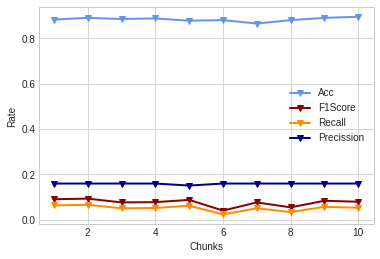

In [0]:
%matplotlib inline
import matplotlib.pyplot as plt
plt.style.use('seaborn-whitegrid')

# multiple line plot
plt.plot( 'Chunks', 'Acc', data=CNNGlove, marker='v', color='cornflowerblue', linewidth=2)
plt.plot( 'Chunks', 'F1Score', data=CNNGlove, marker='v', color='darkred', linewidth=2)
plt.plot( 'Chunks', 'Recall', data=CNNGlove, marker='v', color='darkorange', linewidth=2)
plt.plot( 'Chunks', 'Precission', data=CNNGlove, marker='v', color='darkblue', linewidth=2)
plt.xlabel("Chunks")
plt.ylabel("Rate")
plt.legend()

**References:**

[1] P. Bojanowski, E. Grave, A. Joulin, T. Mikolov, "Enriching Word Vectors with Subword Information", arXiv, 2016  
[2] FastText Embeddings: https://github.com/facebookresearch/fastText/blob/master/pretrained-vectors.md  
[3] F. Chollet, "Deep Learning with Python", Manning Publications, 2017  